In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 10

In [2]:
from patsy import dmatrices

import scipy.stats as st

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors 
    https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible
    """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [4]:
# Load data
auto_df = pd.read_csv('./data/Auto.csv', na_values='?')

auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [5]:
# assert auto_df.isnull().sum().sum() == 0

In [6]:
auto_df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      5
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [7]:
auto_df[auto_df['horsepower']=='?']

/usr/local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name


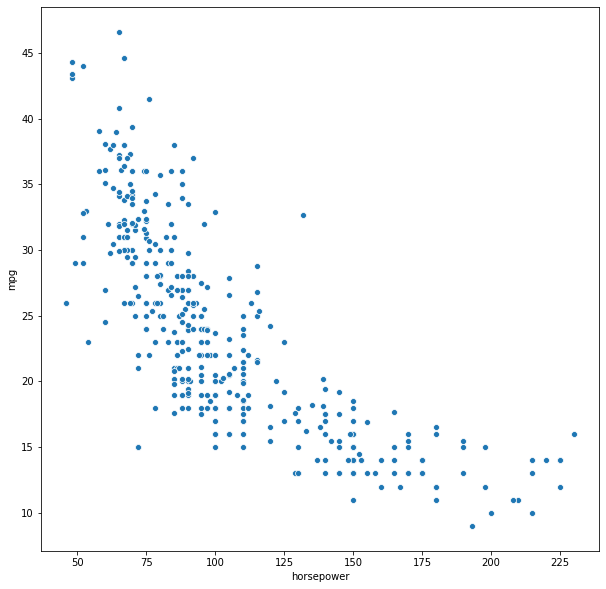

In [8]:
ax = sns.scatterplot(x='horsepower', y='mpg', data=auto_df)

In [9]:
auto_df[~auto_df['horsepower'].isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


In [10]:
clean_auto_df = auto_df[~auto_df['horsepower'].isnull()]

In [11]:
y, X = dmatrices('mpg ~ horsepower', data=auto_df, return_type='dataframe')

In [12]:
model = sm.GLM(y, X)
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    mpg   No. Observations:                  392
Model:                            GLM   Df Residuals:                      390
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          24.066
Method:                          IRLS   Log-Likelihood:                -1178.7
Date:                Tue, 31 Mar 2020   Deviance:                       9385.9
Time:                        20:26:45   Pearson chi2:                 9.39e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.0

In [13]:
print(cross_val_score(SMWrapper(sm.GLM), X, y, cv=10, scoring='neg_mean_squared_error'))

[-28.34783584 -17.22640854 -26.92535793 -23.36016122 -15.55763304
 -17.89383456 -17.04476867 -22.83657872 -65.93489567 -39.27186233]


## Polynomial feature

In [14]:
max_degree = 5
n_cv = 10

kfold_error = np.empty((max_degree,n_cv))

for degree in range(1,max_degree+1):
    y, X = dmatrices('mpg ~ horsepower', data=auto_df, return_type='dataframe')
    polynomial_features= PolynomialFeatures(degree=degree)
    X = polynomial_features.fit_transform(X.values)
    
    cv_error = cross_val_score(SMWrapper(sm.GLM), X, y, cv=n_cv, scoring='neg_mean_squared_error')
    kfold_error[degree-1] = list(cv_error * -1)

Text(0.5, 1.0, 'Cross-validation vs polynomial degrees')

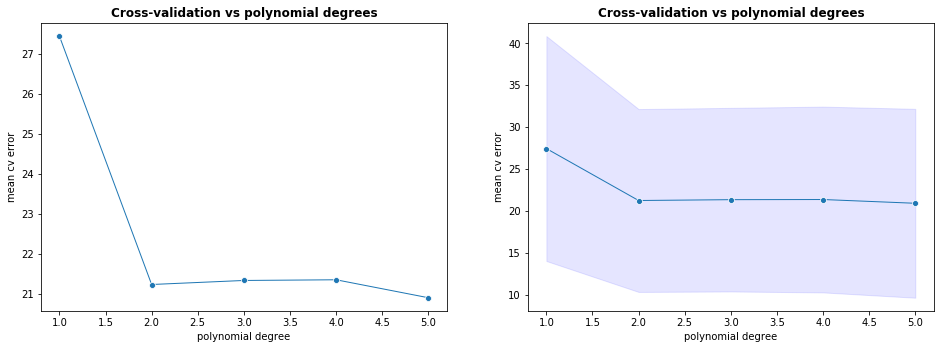

In [15]:
conf_int = st.t.interval(0.95, len(kfold_error)-1, loc=np.mean(kfold_error,axis=1), scale=st.sem(kfold_error,axis=1))

plt.figure(1, figsize=(16, 18))

plt.subplot(321)
ax = sns.lineplot(x=range(1,max_degree+1), y=np.mean(kfold_error,axis=1), lw=1, marker="o")
plt.xlabel('polynomial degree')
plt.ylabel('mean cv error')
plt.title('Cross-validation vs polynomial degrees', fontweight='bold')

plt.subplot(322)
ax = sns.lineplot(x=range(1,max_degree+1), y=np.mean(kfold_error,axis=1), lw=1, marker="o")
ax.fill_between(range(1,max_degree+1),conf_int[0], conf_int[1], color="blue", alpha=0.1)

plt.xlabel('polynomial degree')
plt.ylabel('mean cv error')
plt.title('Cross-validation vs polynomial degrees', fontweight='bold')

In [16]:
max_degree = 5
n_cv = X.shape[0]

loocv_error = np.empty((max_degree,n_cv))

for degree in range(1,6):
    y, X = dmatrices('mpg ~ horsepower', data=auto_df, return_type='dataframe')
    polynomial_features= PolynomialFeatures(degree=degree)
    X = polynomial_features.fit_transform(X.values)
    
    cv_error = cross_val_score(SMWrapper(sm.GLM), X, y, cv=X.shape[0], scoring='neg_mean_squared_error')
    loocv_error[degree-1] = list(cv_error * -1)

Text(0.5, 1.0, 'Cross-validation vs polynomial degrees')

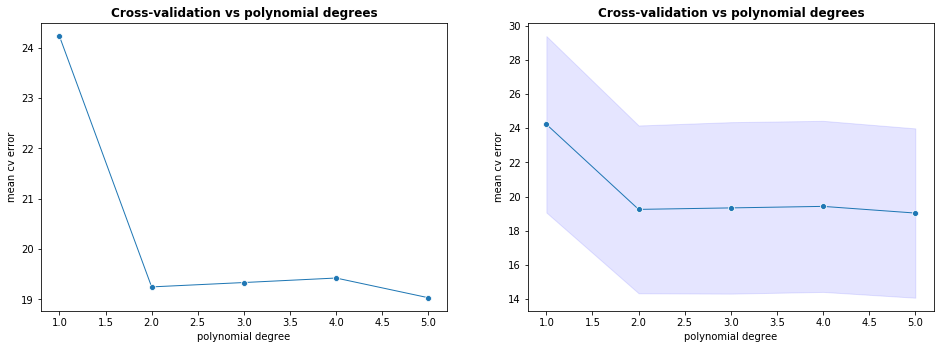

In [17]:
conf_int = st.t.interval(0.95, len(loocv_error)-1, loc=np.mean(loocv_error,axis=1), scale=st.sem(loocv_error,axis=1))

plt.figure(1, figsize=(16, 18))

plt.subplot(321)
ax = sns.lineplot(x=range(1,max_degree+1), y=np.mean(loocv_error,axis=1), lw=1, marker="o")
plt.xlabel('polynomial degree')
plt.ylabel('mean cv error')
plt.title('Cross-validation vs polynomial degrees', fontweight='bold')

plt.subplot(322)
ax = sns.lineplot(x=range(1,max_degree+1), y=np.mean(loocv_error,axis=1), lw=1, marker="o")
ax.fill_between(range(1,max_degree+1),conf_int[0], conf_int[1], color="blue", alpha=0.1)

plt.xlabel('polynomial degree')
plt.ylabel('mean cv error')
plt.title('Cross-validation vs polynomial degrees', fontweight='bold')

## Comparison

In [18]:
dataset1 = pd.DataFrame({'degree': range(1,max_degree+1), 'cv_mean': np.mean(kfold_error,axis=1), 'methode': ['cv-10']*5})
dataset2 = pd.DataFrame({'degree': range(1,max_degree+1), 'cv_mean': np.mean(loocv_error,axis=1), 'methode': ['loocv']*5})
comparison = pd.concat([dataset1, dataset2])


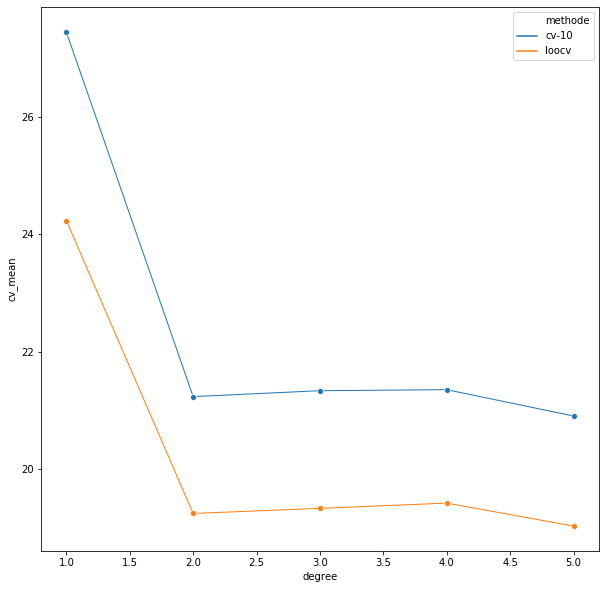

In [19]:
ax = sns.lineplot(x='degree', y='cv_mean', hue='methode', data=comparison, lw=1, marker="o")